<img src="logoFIUBA.jpg" width="300" align="right">


# Vision Transformer (ViT)
## TP N°2

Valentín Pertierra

---

# Vision Transformer (ViT)

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token:

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen.

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer**

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation**

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer

device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  cuda
Torch version:  2.5.0+cu121


In [8]:
# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches


class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):

    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x+self.pos_embedding


In [9]:
# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")

# Transformer Encoder

In [10]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1, batch_first=True):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False, batch_first=batch_first)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model

|               | ViT-Base | ViT-Large | ViT-Huge |
|---------------|----------|-----------|----------|
| **Layers**    | 12       | 24        | 32       |
| **Hidden size D** | 768  | 1024      | 1280     |
| **MLP size**  | 3072     | 4096      | 5120     |
| **Heads**     | 12       | 16        | 16       |
| **Params**    | 86M      | 307M      | 632M     |




In [2]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=900, patch_size=64, in_channels=3, embed_dim=768, num_heads=12, ff_dim=2048,
                 num_layers=12, dropout=0.1, num_classes=10):
        super(VisionTransformer, self).__init__()

        # Genero los embbedings de los parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Defino el positional encoding
        num_patches = (img_size//patch_size)**2
        self.positional_encoding = PositionalEncodingLearned(num_patches, embed_dim)

        # TransformerEncoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)

        # Capa lineal con tantas neuronas como clases se quieren clasificar
        self.output = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        x = self.patch_embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)

        x = x[:, 0]
        x = self.output(x)

        return x

# CIFAR10

In [ ]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 39.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"

In [ ]:

folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

In [ ]:
# A continuacion ingrese los parametros del modelo
num_epochs = 10

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=96,
    num_heads=12,
    ff_dim=1024,
    num_layers=12,
    dropout=0.1,
    num_classes=10
)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)


model = model.to(device)


try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


Parametros del modelo: [Parameter containing:
tensor([[[[-1.2995e-01, -8.5898e-02,  1.0249e-01, -1.0708e-01],
          [-4.5795e-02,  1.4124e-01, -4.4382e-02, -1.3903e-01],
          [-8.2268e-02, -3.4591e-02,  3.9553e-03,  8.3226e-03],
          [ 3.5561e-02,  8.1697e-02,  1.2787e-01, -8.8900e-02]],

         [[ 1.1992e-02, -4.6165e-02,  1.4307e-01, -9.1473e-02],
          [-7.0634e-02, -1.1597e-02, -2.4457e-02, -1.0986e-01],
          [-1.1295e-01, -4.9250e-03, -6.4717e-02,  2.1687e-02],
          [ 7.8155e-02, -1.1771e-01, -3.9777e-02,  4.5296e-02]],

         [[-6.2187e-02,  1.0557e-01,  1.7979e-03, -2.6587e-02],
          [ 6.3693e-03, -1.6929e-02,  1.2199e-01,  3.2002e-02],
          [ 2.9548e-02,  1.2283e-01, -1.2295e-01,  3.2816e-02],
          [-6.0005e-02,  1.4327e-01,  6.6402e-02,  1.0383e-01]]],


        [[[-8.6868e-02, -3.3747e-02,  7.8124e-02,  1.0977e-01],
          [ 1.1464e-01,  5.8677e-02, -1.0459e-01, -1.3491e-01],
          [ 5.8651e-02,  1.0272e-01,  1.0283e-01, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


In [13]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

In [ ]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 1.21 millones


> Se redujo la cantidad de parámetros, en particular se achicó la dimensión de la capa de embedding (de 768 a 96) y la dimensión de la capa feed forward (de 3072 a 1024), porque al momento del entrenamiento superaba la cantidad de memoria máxima de la GPU de Google Colab.

In [ ]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

loss 1.55752: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


In [14]:
def evaluate_model(model, data_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images = images.to(device).float()
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, precision, recall, f1

In [ ]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)


100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


In [ ]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.41
Precision: 0.40
Recall: 0.41
F1 score: 0.40


In [ ]:
train_dataset.data[0].shape

(32, 32, 3)

In [15]:
def visualize_classification(model, data_loader, class_names, num_images=16):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 4, 4, images_so_far)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[j]]}\nPred: {class_names[preds[j]]}')
                img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    return

class_names = train_dataset.classes

  0%|          | 0/20 [00:01<?, ?it/s]


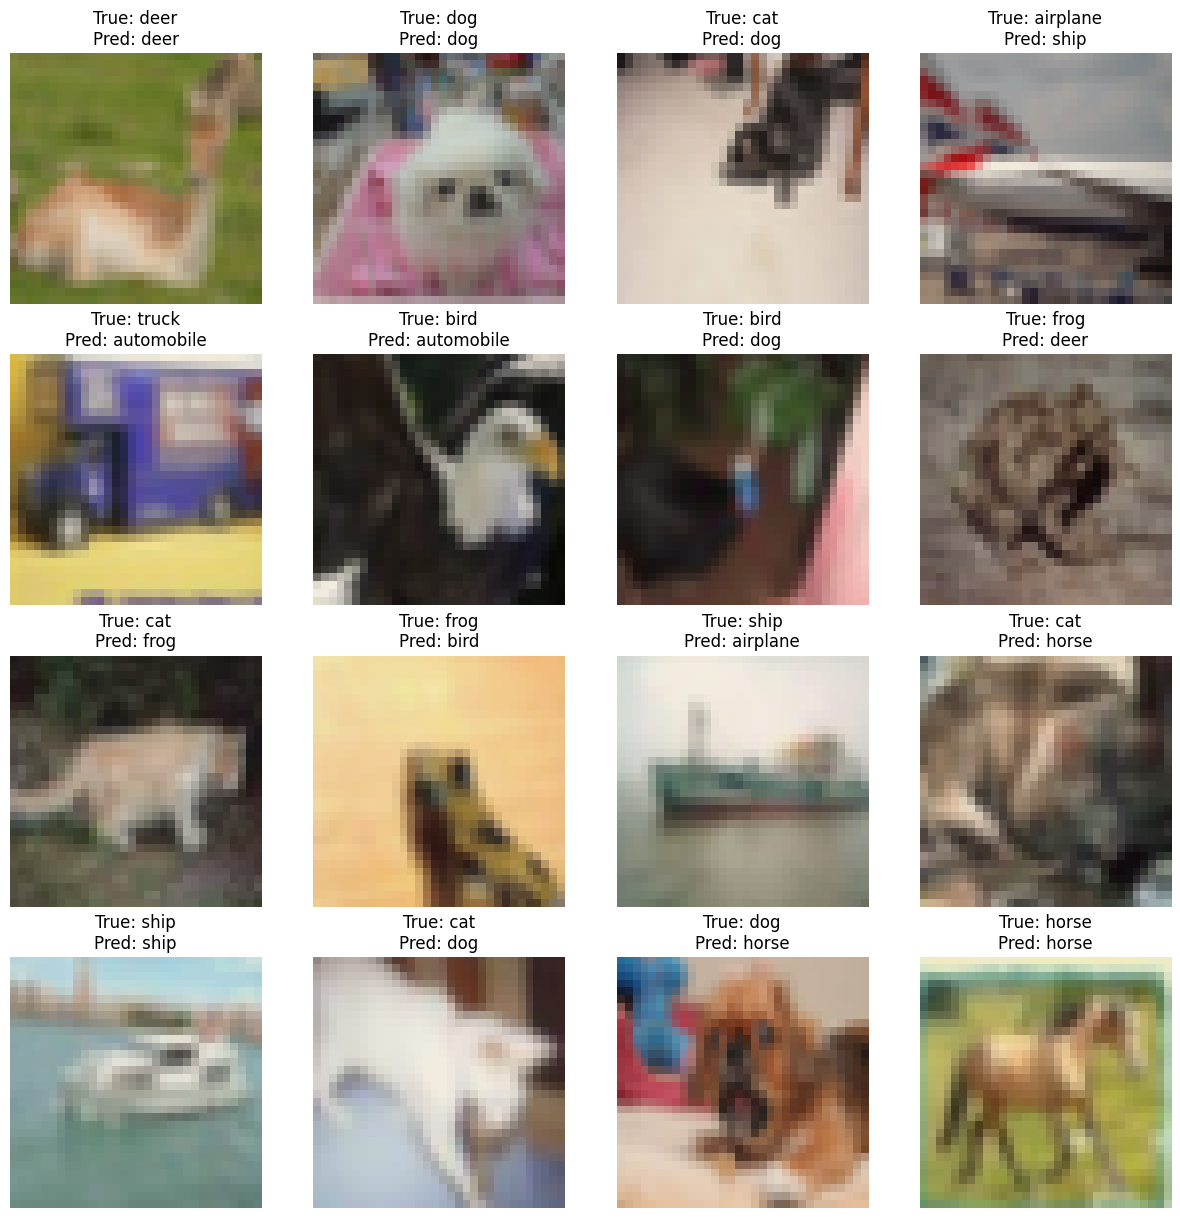

In [ ]:
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()


### Data Augmentation
Se aplican diversas transformaciones a las imágenes para enriquecer el conjunto de datos y mejorar la capacidad de generalización del modelo

In [25]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),                                              # Flip horizontal aleatorio
    transforms.RandomVerticalFlip(),                                                # Flip vertical aleatorio
    transforms.RandomRotation(degrees=15),                                          # Rotacion aleatoria de +-15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Cambio aleatorio del color
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),     # Crop y resize aleatorio
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),                       # Desplazamiento aleatorio
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Al set de test no lo modifico, solo le aplico la normalizacion
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)

# Al set de test no le aplico ninguna transformacion, la idea es no alterar estas imagenes
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


In [31]:
num_epochs = 10

model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=96,
    num_heads=12,
    ff_dim=1024,
    num_layers=12,
    dropout=0.1,
    num_classes=10
)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

Parametros del modelo: [Parameter containing:
tensor([[[[ 0.0011, -0.0481, -0.0299,  0.0681],
          [ 0.0920, -0.0291, -0.1250, -0.0074],
          [-0.0669,  0.0003, -0.0962, -0.0892],
          [ 0.0781, -0.0597,  0.0824, -0.0261]],

         [[ 0.0897,  0.1332,  0.0991,  0.0060],
          [-0.0995, -0.0363, -0.0407, -0.0431],
          [-0.1214,  0.0621, -0.0922,  0.0355],
          [ 0.1292, -0.0926, -0.1093,  0.1057]],

         [[-0.1381, -0.0147, -0.1061,  0.1039],
          [-0.0058, -0.0809, -0.1133,  0.0865],
          [ 0.0711, -0.0487,  0.0092, -0.0853],
          [ 0.0034,  0.1251, -0.0208,  0.1097]]],


        [[[-0.0864,  0.1194,  0.0826, -0.1282],
          [ 0.0358, -0.0553, -0.0512, -0.0791],
          [ 0.0534, -0.0615, -0.0926,  0.0955],
          [-0.0038,  0.0570, -0.1174, -0.0021]],

         [[ 0.1116, -0.1055, -0.1408, -0.1338],
          [ 0.0961, -0.1225, -0.1256,  0.1359],
          [-0.0958, -0.0200,  0.0948, -0.0581],
          [-0.0082, -0.1011, -0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


In [32]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
num_epochs = 10
for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

loss 1.82719: 100%|██████████| 98/98 [02:05<00:00,  1.29s/it]


In [33]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


In [34]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.35
Precision: 0.35
Recall: 0.35
F1 score: 0.33


  0%|          | 0/20 [00:00<?, ?it/s]


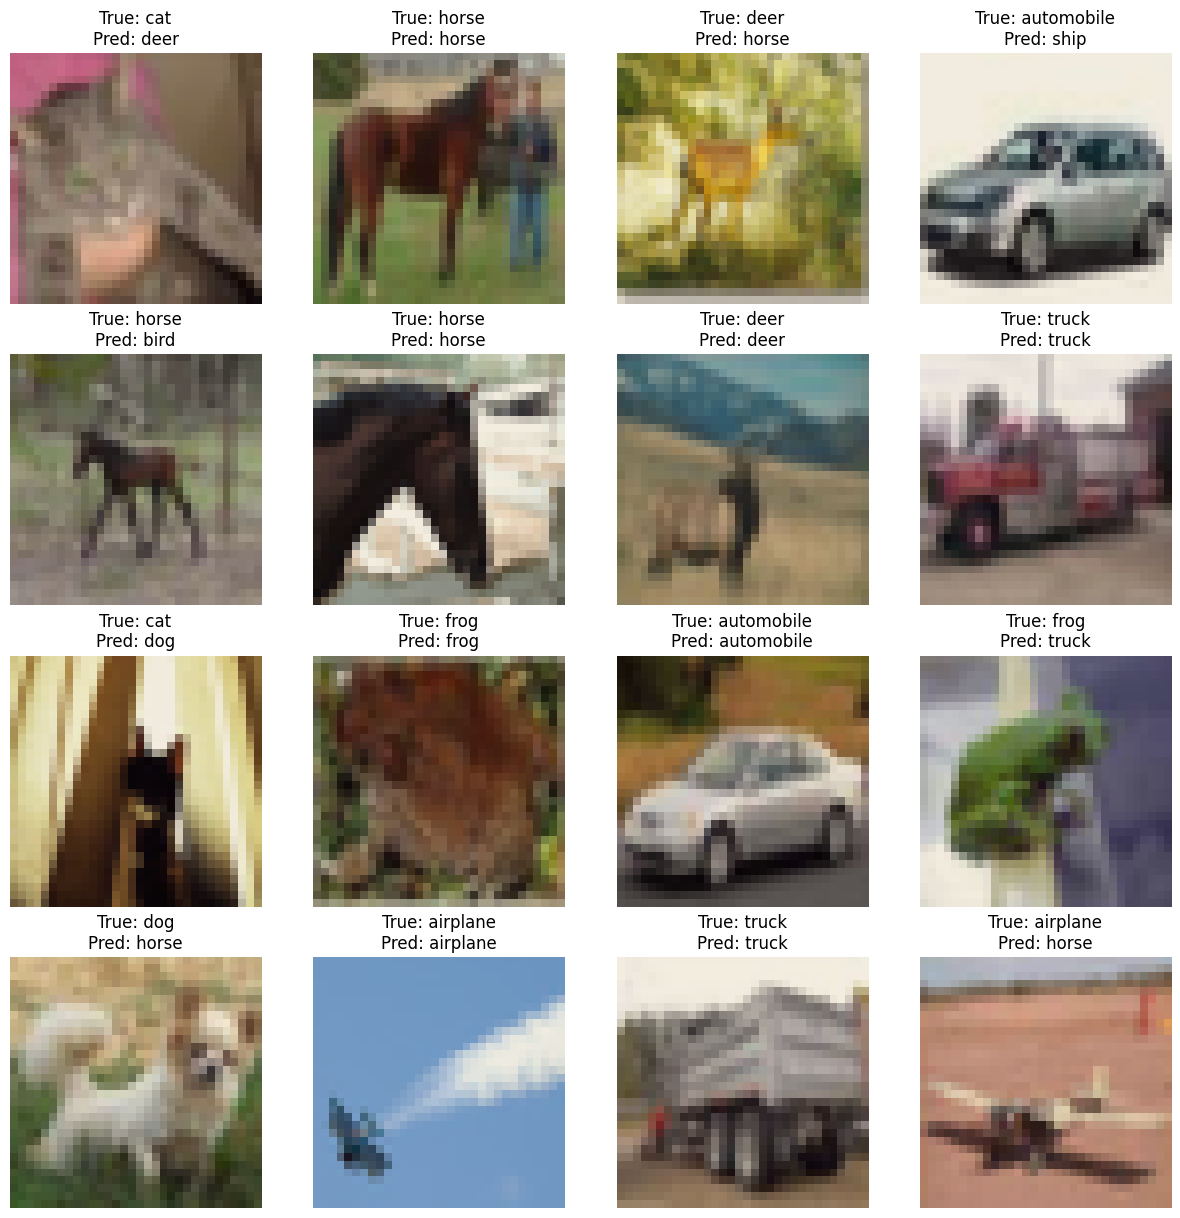

In [35]:
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

### Entrenamiento de modelo mas grande (ViT-Large)

Intento reducir el batch size para entrenar un modelo mas grande sin que se llene el espacio de la GPU

In [36]:
num_epochs = 10


model = VisionTransformer(
    img_size=32,
    patch_size=4,
    embed_dim=1024,
    num_heads=16,
    ff_dim=4096,
    num_layers=24,
    dropout=0.1,
    num_classes=10
)

print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn was passed bias=False
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.1022, -0.0691, -0.0615,  0.0797],
          [ 0.0780,  0.0895,  0.0531,  0.1078],
          [ 0.0281, -0.0625, -0.0999,  0.0697],
          [-0.0262,  0.0589, -0.1240,  0.1022]],

         [[ 0.1097,  0.1351,  0.0230, -0.0623],
          [ 0.0170, -0.0090,  0.1047, -0.1051],
          [ 0.0790,  0.0868,  0.1242, -0.0124],
          [-0.1339,  0.0063,  0.1013, -0.0991]],

         [[-0.0980, -0.1014,  0.0275, -0.1327],
          [-0.0232,  0.0782, -0.0677,  0.0812],
          [ 0.0908,  0.0714, -0.1022, -0.0978],
          [-0.0654,  0.1171,  0.0499,  0.1228]]],


        [[[ 0.0664, -0.0290,  0.1074,  0.0007],
          [-0.1373,  0.1437, -0.0616, -0.0370],
          [-0.1178,  0.0714, -0.0428, -0.0007],
          [ 0.0110,  0.0404, -0.1198, -0.0313]],

         [[-0.0121,  0.0039,  0.0943,  0.0644],
          [ 0.1278, -0.0413, -0.1413, -0.0367],
          [-0.1284,  0.0627, -0.0896, -0.0849],
          [ 0.0076,  0.1425,  0.

In [37]:
torch.cuda.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 302.17 millones


In [43]:
from torch.utils.data import Subset

In [46]:
# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
])

# Load your dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'train_dataset: {len(train_dataset)}')
print(f'test_dataset: {len(test_dataset)}')

# Achico la cantidad de imagenes para que el entrenamiento no dure tanto tiempo
fraction = 0.1    # Me quedo con el 10% de las imagenes
train_subset = Subset(train_dataset, np.random.choice(len(train_dataset), int(len(train_dataset) * fraction), replace=False))
test_subset = Subset(test_dataset, np.random.choice(len(test_dataset), int(len(test_dataset) * fraction), replace=False))

print(f'train_subset: {len(train_subset)}')
print(f'test_subset: {len(test_subset)}')

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
train_dataset: 50000
test_dataset: 10000
train_subset: 5000
test_subset: 1000


In [47]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)
num_epochs = 10
for epoch in range(num_epochs):

    trainer.train_model(use_amp=True)
    scheduler.step()

loss 2.34180: 100%|██████████| 79/79 [04:30<00:00,  3.42s/it]


In [48]:
# Evaluar el modelo
accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

100%|██████████| 16/16 [00:11<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 0.11
Precision: 0.01
Recall: 0.10
F1 score: 0.02


  0%|          | 0/16 [00:00<?, ?it/s]


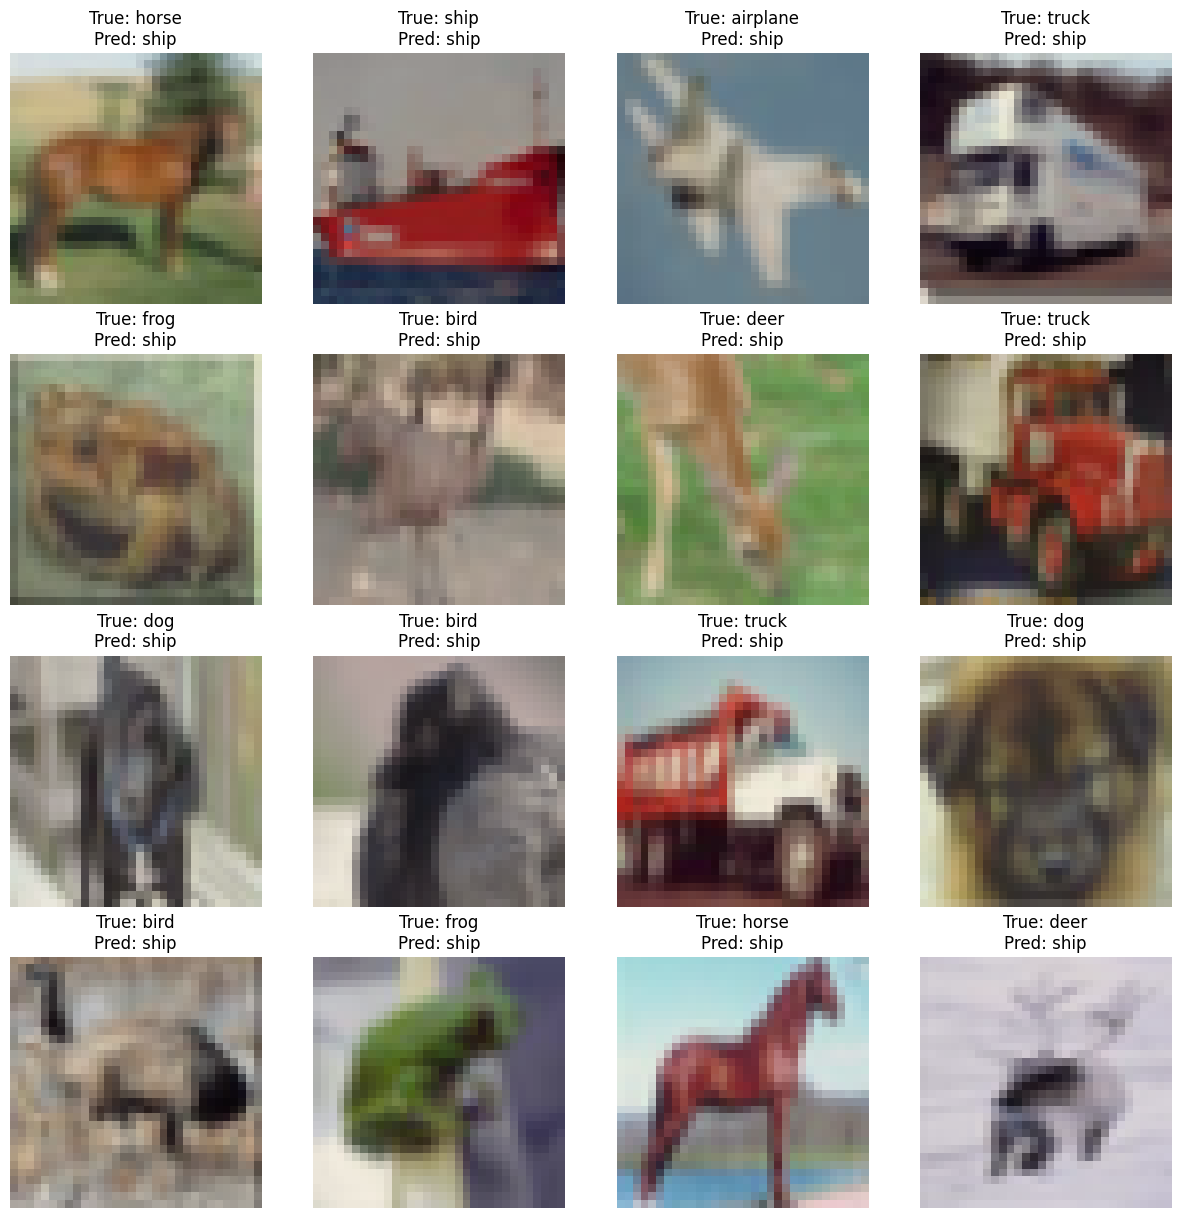

In [50]:
visualize_classification(model, test_loader, class_names, num_images=16)
plt.show()

### Conclusiones

En este trabajo practico se implementó la arquitectura de un vision transformer para clasificar las imágenes de CIFAR10.

En primer lugar, se desarrolló una arquitectura con menos parámetros que el ViT-Base ya que al momento de entrenarlo superaba la memoria de la GPU del Google Colab. El modelo logro clasificar las imágenes.

Posteriormente, para resolver la falta de memoria se redujo el tamaño del batch de entrenamiento. Esta permitió entrenar un modelo de mayor tamaño, similar al ViT-Large, aunque el resultado obtenido en cuanto a las métricas no fue satisfactorio. Para poder entrenar el modelo sin que demore un tiempo excesivo, se redujo la cantidad de imágenes en los sets de entrenamiento y testeo (se utilizó el 10% del dataset original). La reducción del dataset pudo haber afectado el entrenamiento y dificultado la obtención de buenas métricas, a pesar de que la función de costo disminuyo a lo largo de las epochs.

Por otro lado, se probo realizar otras transformaciones al dataset original, distintas a las propuestas en el TP, con el modelo reducido. Se logro entrenar y obtener métricas aceptables, aunque inferiores al primer modelo. Esto pudo deberse a que las transformaciones realizadas fueron muy agresivas y alteraron considerablemente la información original de las imágenes o que el modelo necesitó más tiempo de entrenamiento para lograr mejores resultados. 
